In [6]:
import json
from tqdm import tqdm
from unidecode import unidecode
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
def percent_dict(dict, total):
    return_dict = {}
    for key, value in dict.items():
        percentage = value/total
        return_dict[key] = percentage

    return return_dict

def check(dict):
    total = 0
    for val in dict.values():
        total += val
    total = float(format(total, ".4f"))
    if total == 1:
        return True
    else:
        return total
    
def total(dict):
    tot = 0
    for val in dict.values():
        tot += val
    return tot

def mean_squared_error(dict1, dict2):
    keys = dict1.keys()  # Assuming both dictionaries have the same keys
    
    squared_diff_sum = 0
    for key in keys:
        squared_diff = (dict1[key] - dict2[key]) ** 2
        squared_diff_sum += squared_diff
    
    mse = squared_diff_sum / len(keys)
    return mse

In [19]:
with open("C:/Users/alpye/OneDrive/Desktop/pure/FindGeoLocation/trial_data_gathered/accumulation/guess/3)coordinates.json", "r") as file:
    whole = json.load(file)

whole_dict = percent_dict(whole, total(whole)) 
check(whole_dict)

True

In [17]:
with open("data/populations.json", "r", encoding="utf-8") as file:
    population_list = json.load(file)

pop_dict = {}

population_list = sorted(population_list, key=lambda x: unidecode(x["name"]))

for item in population_list:
    name = unidecode(item["name"].lower())
    pop_dict[name] = item["population"]

obs_dict = percent_dict(pop_dict, total(pop_dict))
check(obs_dict)
# Now we have the percentages of populations by ratio to the whole population number

True

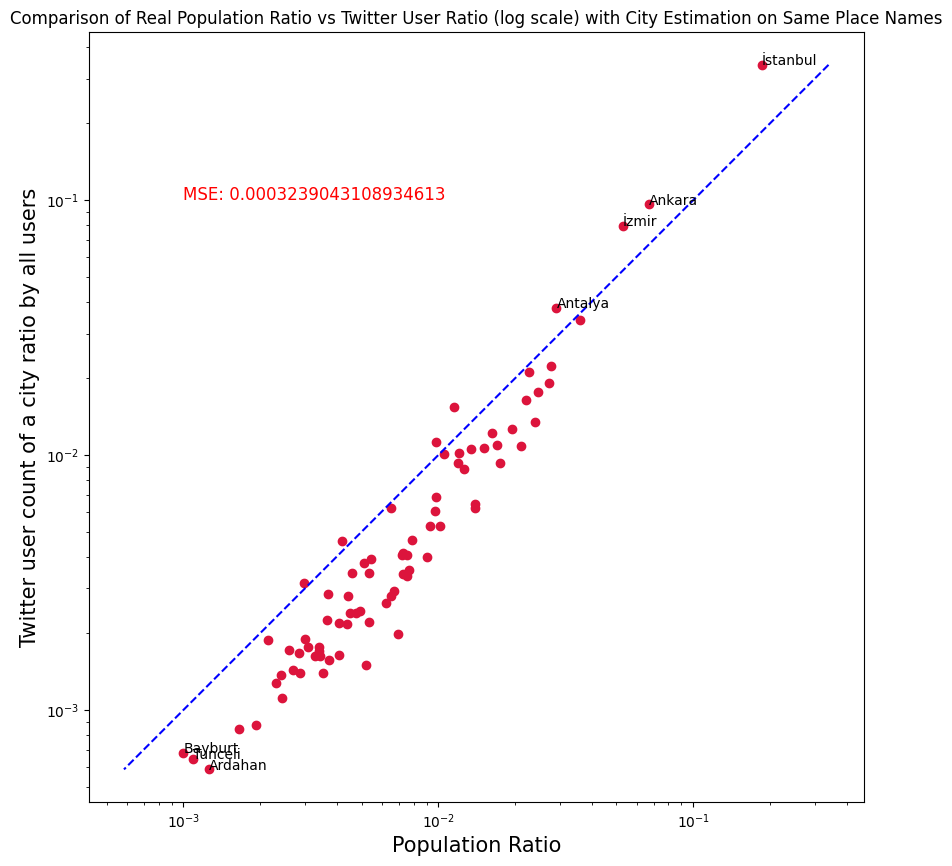

In [20]:
observed_keys = list(obs_dict.keys())
observed_values = list(obs_dict.values())
estimated_values = [whole_dict[key] for key in observed_keys]

plt.figure(figsize=(10,10))
plt.scatter(observed_values, estimated_values, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(estimated_values), max(observed_values))
p2 = min(min(estimated_values), min(observed_values))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('Population Ratio', fontsize=15)
plt.ylabel('Twitter user count of a city ratio by all users', fontsize=15)
plt.axis('equal')
plt.title("Comparison of Real Population Ratio vs Twitter User Ratio (log scale) with City Estimation on Same Place Names")

plt.annotate("İzmir", (obs_dict["izmir"],whole_dict["izmir"]))
plt.annotate("Ankara", (obs_dict["ankara"], whole_dict["ankara"]))
plt.annotate("İstanbul", (obs_dict["istanbul"], whole_dict["istanbul"]))
plt.annotate("Ardahan", (obs_dict["ardahan"], whole_dict["ardahan"]))
plt.annotate("Tunceli", (obs_dict["tunceli"], whole_dict["tunceli"]))
plt.annotate("Bayburt", (obs_dict["bayburt"], whole_dict["bayburt"]))
plt.annotate("Antalya", (obs_dict["antalya"], whole_dict["antalya"]))

'''for key, x, y in zip(obs_dict.keys(), obs_dict.values(), whole_dict.values()):
    plt.annotate(key, (x, y), textcoords="offset points", xytext=(0,10), ha='center')'''


text_x = 0.001  # X-coordinate of the text
text_y = 0.1  # Y-coordinate of the text

text_content = 'MSE: ' + str(mean_squared_error(obs_dict,whole_dict))
plt.text(text_x, text_y, text_content, fontsize=12, color='red')

plt.savefig('graphs/2.png')

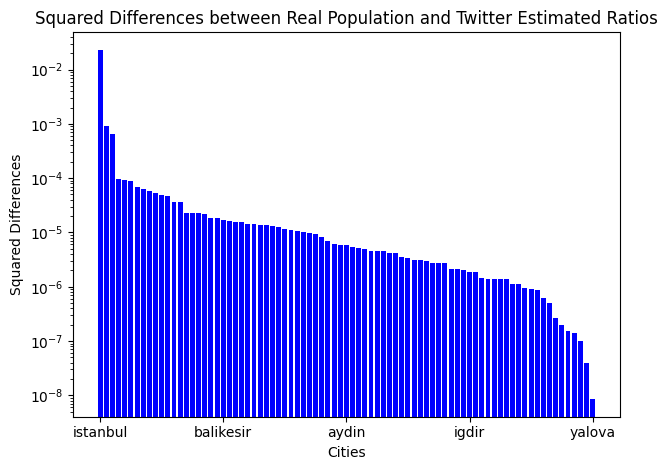

In [40]:
squared_diffs = [(key, (obs_dict[key] - whole_dict[key]) ** 2) for key in obs_dict]
squared_diffs.sort(key=lambda x: x[1], reverse=True)  # Sort by squared difference

# Extract keys and squared differences for plotting
keys = [item[0] for item in squared_diffs]
squared_differences = [item[1] for item in squared_diffs]

# Create a bar graph
plt.bar(keys, squared_differences, color='blue')
plt.xlabel('Cities')
plt.ylabel('Squared Differences')
plt.title('Squared Differences between Real Population and Twitter Estimated Ratios')

top = len(squared_differences)-1
half = len(squared_differences)//2
quarter = len(squared_differences)//4

show_ticks = [0, half-quarter, half, half+quarter, top]
plt.xticks(show_ticks, [keys[i] for i in show_ticks])

plt.yscale('log')

# Show the plot
plt.tight_layout()

plt.savefig('graphs/difference/all_cities.png')


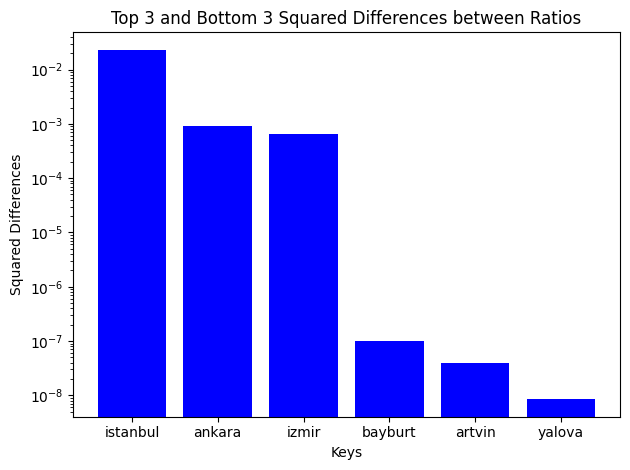

In [41]:
top_3 = squared_diffs[:3]
bottom_3 = squared_diffs[-3:]
bars = top_3 + bottom_3
keys = [item[0] for item in bars]
squared_differences = [item[1] for item in bars]

# Create a bar graph
plt.bar(range(len(bars)), squared_differences, color='blue')
plt.xlabel('Keys')
plt.ylabel('Squared Differences')
plt.title('Top 3 and Bottom 3 Squared Differences between Ratios')

# Customize x-axis ticks and labels
plt.xticks(range(len(bars)), keys)

plt.yscale('log')

# Show the plot
plt.tight_layout()

plt.savefig('graphs/difference/top3_bottom3.png')


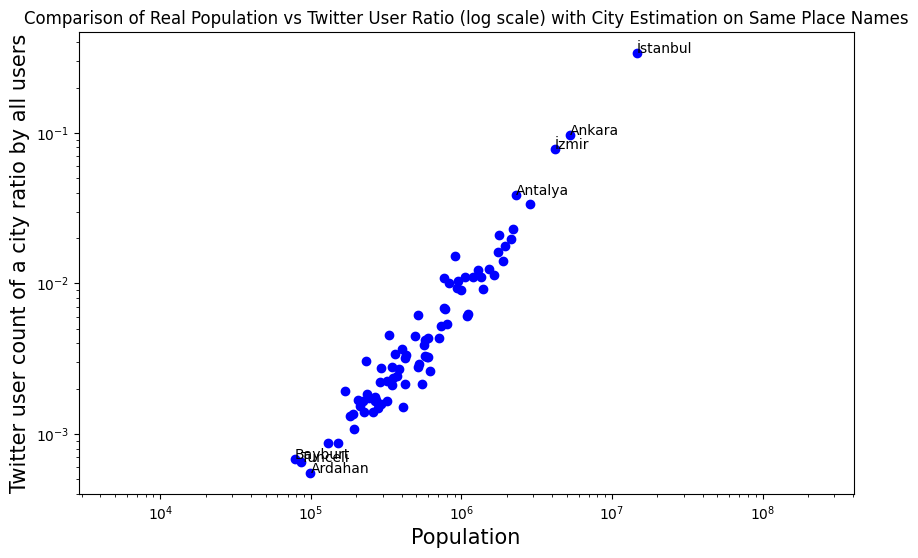

In [10]:
cities = list(pop_dict.keys())
populations = list(pop_dict.values())
proportions = list(whole_dict.values())

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.scatter(populations, proportions, color='blue', marker='o')

plt.yscale('log')
plt.xscale('log')

plt.annotate("İzmir", (pop_dict["izmir"],whole_dict["izmir"]))
plt.annotate("Ankara", (pop_dict["ankara"], whole_dict["ankara"]))
plt.annotate("İstanbul", (pop_dict["istanbul"], whole_dict["istanbul"]))
plt.annotate("Ardahan", (pop_dict["ardahan"], whole_dict["ardahan"]))
plt.annotate("Tunceli", (pop_dict["tunceli"], whole_dict["tunceli"]))
plt.annotate("Bayburt", (pop_dict["bayburt"], whole_dict["bayburt"]))
plt.annotate("Antalya", (pop_dict["antalya"], whole_dict["antalya"]))

plt.xlabel('Population', fontsize=15)
plt.ylabel('Twitter user count of a city ratio by all users', fontsize=15)
plt.axis('equal')
plt.title("Comparison of Real Population vs Twitter User Ratio (log scale) with City Estimation on Same Place Names")


plt.savefig('graphs/whole_data2.png')

In [11]:
with open("C:/Users/alpye/OneDrive/Desktop/pure_git/FindGeoLocation/gathered_data/whole_results/trial_data_save.json", "r") as file:
    compare_guess = json.load(file)

compare_guess_dict = percent_dict(compare_guess, total(compare_guess))
check(compare_guess_dict)

True

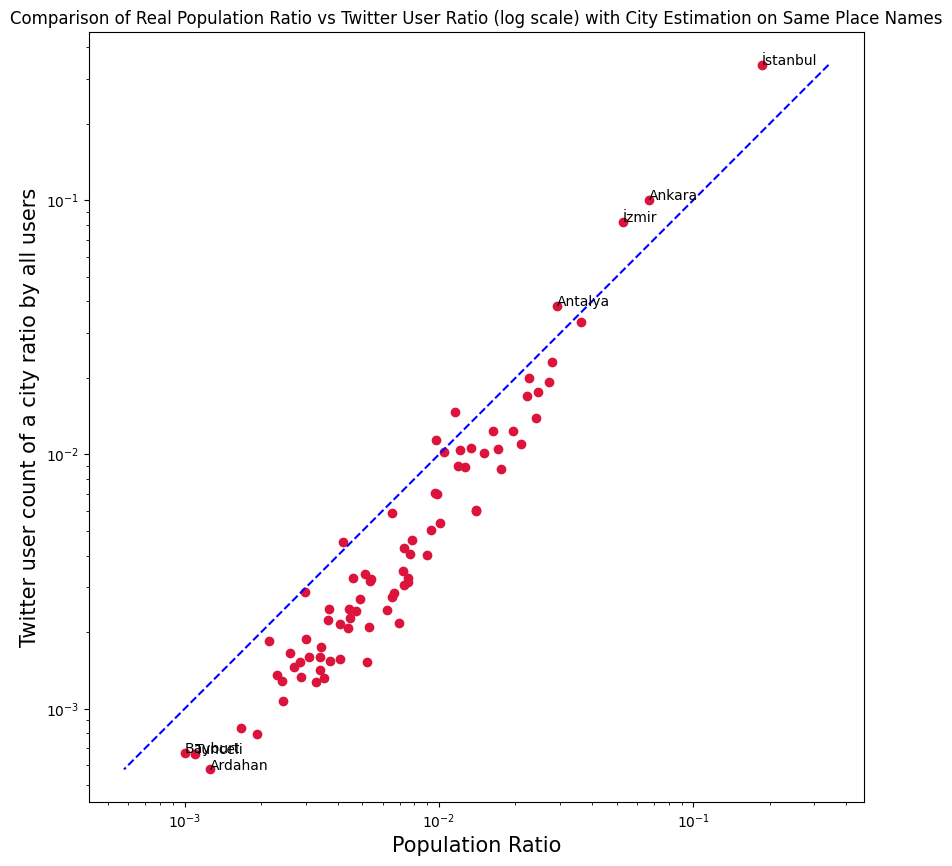

In [12]:
observed_keys = list(obs_dict.keys())
observed_values = list(obs_dict.values())
estimated_values = [compare_guess_dict[key] for key in observed_keys]

plt.figure(figsize=(10,10))
plt.scatter(observed_values, estimated_values, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(estimated_values), max(observed_values))
p2 = min(min(estimated_values), min(observed_values))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('Population Ratio', fontsize=15)
plt.ylabel('Twitter user count of a city ratio by all users', fontsize=15)
plt.axis('equal')
plt.title("Comparison of Real Population Ratio vs Twitter User Ratio (log scale) with City Estimation on Same Place Names")

plt.annotate("İzmir", (obs_dict["izmir"],compare_guess_dict["izmir"]))
plt.annotate("Ankara", (obs_dict["ankara"], compare_guess_dict["ankara"]))
plt.annotate("İstanbul", (obs_dict["istanbul"], compare_guess_dict["istanbul"]))
plt.annotate("Ardahan", (obs_dict["ardahan"], compare_guess_dict["ardahan"]))
plt.annotate("Tunceli", (obs_dict["tunceli"], compare_guess_dict["tunceli"]))
plt.annotate("Bayburt", (obs_dict["bayburt"], compare_guess_dict["bayburt"]))
plt.annotate("Antalya", (obs_dict["antalya"], compare_guess_dict["antalya"]))


plt.savefig('graphs/first_method_guess.png')

In [13]:
with open("C:/Users/alpye/OneDrive/Desktop/pure_git/FindGeoLocation/gathered_data/whole_results/trial_data_saveWO1.json", "r") as file:
    compare_WOguess = json.load(file)

compare_WOguess_dict = percent_dict(compare_WOguess, total(compare_WOguess))
check(compare_WOguess_dict)

True

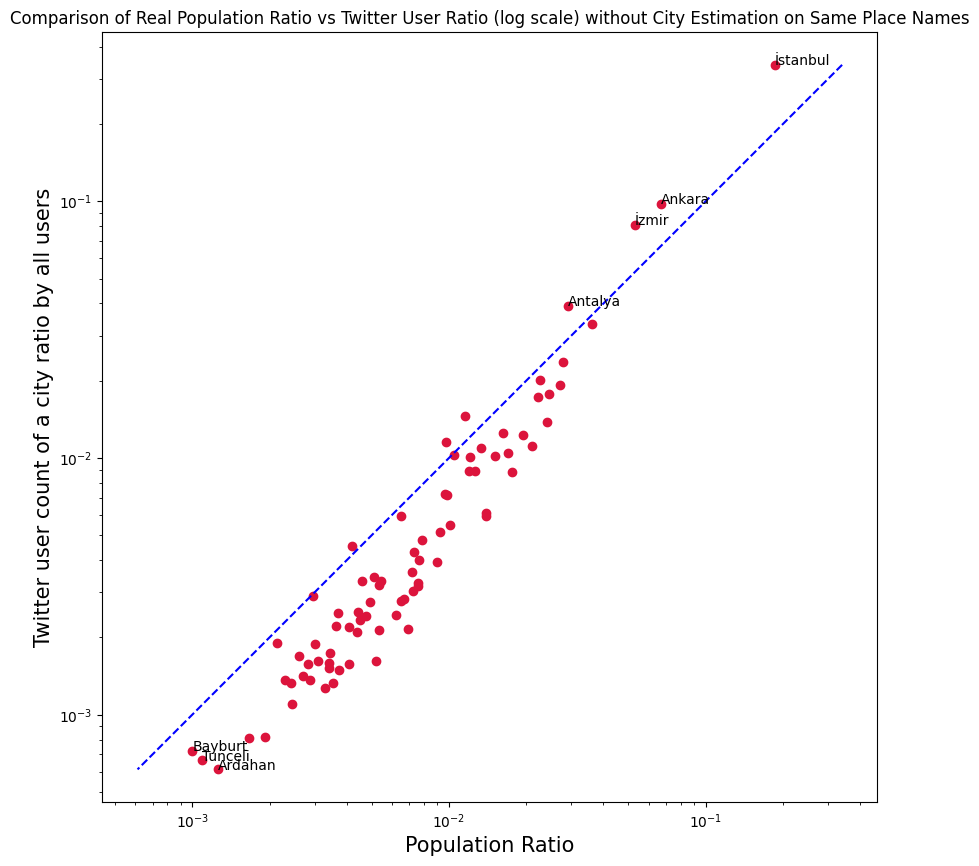

In [14]:
observed_keys = list(obs_dict.keys())
observed_values = list(obs_dict.values())
estimated_values = [compare_WOguess_dict[key] for key in observed_keys]

plt.figure(figsize=(10,10))
plt.scatter(observed_values, estimated_values, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(estimated_values), max(observed_values))
p2 = min(min(estimated_values), min(observed_values))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('Population Ratio', fontsize=15)
plt.ylabel('Twitter user count of a city ratio by all users', fontsize=15)
plt.axis('equal')
plt.title("Comparison of Real Population Ratio vs Twitter User Ratio (log scale) without City Estimation on Same Place Names")

plt.annotate("İzmir", (obs_dict["izmir"],compare_WOguess_dict["izmir"]))
plt.annotate("Ankara", (obs_dict["ankara"], compare_WOguess_dict["ankara"]))
plt.annotate("İstanbul", (obs_dict["istanbul"], compare_WOguess_dict["istanbul"]))
plt.annotate("Ardahan", (obs_dict["ardahan"], compare_WOguess_dict["ardahan"]))
plt.annotate("Tunceli", (obs_dict["tunceli"], compare_WOguess_dict["tunceli"]))
plt.annotate("Bayburt", (obs_dict["bayburt"], compare_WOguess_dict["bayburt"]))
plt.annotate("Antalya", (obs_dict["antalya"], compare_WOguess_dict["antalya"]))

plt.savefig('graphs/first_method_WOguess.png')